## Testing different ensembling combinations

In [14]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
import timeit
import matplotlib.pyplot as plt
from random import shuffle

from sklearn import linear_model, preprocessing
from sklearn.cluster import KMeans
from collections import defaultdict

from keras.models import Sequential
from keras.layers import Dense, Dropout
# fix random seed for reproducibility
np.random.seed(7)
path = os.getcwd()

In [71]:
#### CALCULATE WRMSE FOR ALL THE RESULTS FILES 

indices = []
for i in range(10):
    for j in range(10):
        for k in range(10):
            indices.append((0.1*i, 0.1*j, 0.1*k))

best_wrmse = 10**99
for sample in indices:   
    num = 0 
    denom = 0  
    zone_21 = np.zeros(1344)

    for zone in range(1, 21):
        base_data = pd.read_csv(path + '/NN_inputs/Neural_results_z{}' + str(zone) + '.csv')
        wave_data = pd.read_csv(path + '/NN_inputs/wavelet_prediction_z{}.csv'.format(str(zone)))
        par_data = pd.read_csv(path + '/NN_inputs/parametric_prediction_z{}.csv'.format(str(zone)))
        
        actual = np.array(base_data['actual'])
        neural = np.array(base_data['predicted_NN'])
        parametric = np.array(par_data['predicted'])
        wavelet = np.array(wave_data['predicted_NN'])
        
        #choose random numbers
        
        random = np.array(sample)
        
        if np.sum(random) == 0:
            random = [0.333, 0.333,0.333]
        else:
            random /= np.sum(random)
        
    
        final = random[0] * neural + random[1] * parametric + random[2] * wavelet
        
        diffs = actual - final
        zone_21 += diffs 

        diffs = np.reshape(diffs,(24,int(len(diffs)/24)))
        diffs = diffs[:,np.random.choice(56, 14)] ** 2
        num +=  np.sum(diffs)
        denom += diffs.shape[0] * diffs.shape[1]


    if True:
        zone_21 = np.reshape(zone_21,(24,int(len(zone_21)/24)))
        zone_21 = zone_21[:,np.random.choice(56, 14)]
        
        zone_21 = (zone_21 ** 2) * 20

        num += np.sum(zone_21)
        denom += 14 * 24 * 20

    wrmse = (num/denom) ** 0.5
    if wrmse < best_wrmse:
        print (wrmse, random)
        best_wrmse = wrmse
        params = random

119132.778087
119132.778087 [1 0 0]
81501.9217445
81501.9217445 [0 1 0]
123749.406788


In [74]:
zonemse = defaultdict(dict)

for arch in ['p', 'n', 'w', 'e']:
    num = 0 
    denom = 0  
    for zone in range(1, 21):
        num = 0 
        denom = 0
        base_data = pd.read_csv(path + '/NN_inputs/Neural_results_z{}' + str(zone) + '.csv')
        wave_data = pd.read_csv(path + '/NN_inputs/wavelet_prediction_z{}.csv'.format(str(zone)))
        par_data = pd.read_csv(path + '/NN_inputs/parametric_prediction_z{}.csv'.format(str(zone)))

        actual = np.array(base_data['actual'])
        neural = np.array(base_data['predicted_NN'])
        parametric = np.array(par_data['predicted'])
        wavelet = np.array(wave_data['predicted_NN'])

        #choose random numbers
        if arch == 'p':
            final = parametric
        elif arch == 'n':
            final = neural
        elif arch == 'w':
            final = wavelet
        elif arch == 'e':
            final = 1 / 9 * neural + 7 / 9 * parametric + 1 / 9 * wavelet

        diffs = actual - final

        diffs = np.reshape(diffs,(24,int(len(diffs)/24)))
        diffs = diffs[:,np.random.choice(56, 14)] ** 2
        num +=  np.sum(diffs)
        denom += 14*24

        #print(zone, 1000 * np.sum(diffs) / sum(zone_data['actual'] ** 2))


        wrmse = (num/denom) ** 0.5
        wrmse /= (np.sum(final) / len(final))
        
        zonemse[arch][zone] = wrmse

In [97]:
for arch in ['p', 'n', 'w', 'e']:
    print ([float(int(zonemse[arch][i] * 100)) / 100 for i in range(1, 21)])

[0.1, 0.07, 0.08, 0.13, 0.14, 0.07, 0.07, 0.09, 0.22, 0.17, 0.09, 0.1, 0.1, 0.13, 0.1, 0.13, 0.08, 0.09, 0.11, 0.08]
[0.13, 0.1, 0.12, 0.13, 0.18, 0.11, 0.1, 0.12, 0.32, 0.3, 0.13, 0.15, 0.11, 0.17, 0.11, 0.13, 0.1, 0.17, 0.15, 0.12]
[0.11, 0.13, 0.1, 0.13, 0.18, 0.1, 0.09, 0.12, 0.27, 0.48, 0.13, 0.17, 0.16, 0.15, 0.11, 0.17, 0.14, 0.16, 0.13, 0.1]
[0.09, 0.07, 0.07, 0.11, 0.14, 0.07, 0.07, 0.09, 0.24, 0.15, 0.09, 0.11, 0.1, 0.11, 0.11, 0.11, 0.07, 0.1, 0.1, 0.08]


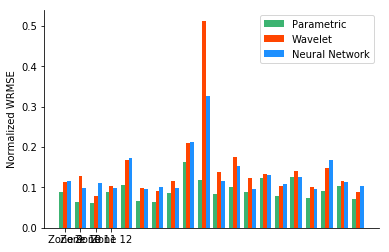

In [72]:
ind = 0
color = {}
color['p'] = 'mediumseagreen'
color['n'] = 'dodgerblue'
color['w'] = 'orangered'
label = {}
label['p'] = 'Parametric'
label['n'] = 'Neural Network'
label['w'] = 'Wavelet'

plt.clf()
ax = plt.subplot(111)
for zone in range(1, 21):
    for model in ['p', 'w', 'n']:
        if zone == 9:
            lbl = label[model]
        else:
            lbl = None
        ax.bar(ind, zonemse[model][zone], 1, color = color[model], label = lbl)
        ind += 1
    ind += 1
plt.xticks((1, 5,  9, 13), ('Zone 9', 'Zone 10', 'Zone 11', 'Zone 12'))
plt.ylabel('Normalized WRMSE')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.savefig(path + '/plots/wrmsebar.png', bbox_inches='tight', transparent=True)
plt.show()

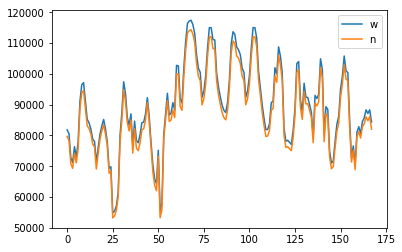

In [160]:
#plt.plot(parametric[:168], label = 'p')
plt.plot(wavelet[:168], label = 'w')
plt.plot(neural[:168], label = 'n')
#plt.plot(actual[:168], label = 'a')
plt.legend()
plt.show()


In [68]:
#### CALCULATE WRMSE FOR ALL THE RESULTS FILES 
#def evaluate(includeTotalZone):

indices = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (0.11111111,  0.77777778,  0.11111111)]
            
for sample in indices:   
    num = 0 
    denom = 0  
    zone_21 = np.zeros(1344)

    for zone in range(1, 21):
        base_data = pd.read_csv(path + '/NN_inputs/Neural_results_z{}' + str(zone) + '.csv')
        wave_data = pd.read_csv(path + '/NN_inputs/wavelet_prediction_z{}.csv'.format(str(zone)))
        par_data = pd.read_csv(path + '/NN_inputs/parametric_prediction_z{}.csv'.format(str(zone)))
        
        actual = np.array(base_data['actual'])
        neural = np.array(base_data['predicted_NN'])
        parametric = np.array(par_data['predicted'])
        wavelet = np.array(wave_data['predicted_NN'])
        
        #choose random numbers
        
        random = np.array(sample)
        
        final = random[0] * neural + random[1] * parametric + random[2] * wavelet
        
        diffs = actual - final
        x = 1344
        zone_21 += diffs 
        denom += x
       

        diffs = np.reshape(diffs,(24,int(len(diffs)/24))) ** 2
        num +=  np.sum(diffs)

    if True:
        zone_21 = np.reshape(zone_21,(24,int(len(zone_21)/24)))

        zone_21 = (zone_21 ** 2) * 20
        print (x)
        num += np.sum(zone_21)
        denom += x * 20

    wrmse = (num/denom) ** 0.5         
    
    print (wrmse)

1344
123245.608313
1344
84308.5626712
1344
120097.133422
1344
83673.7394543
